This jupyter notebook hosts the code for simulated data experiments, SI-1 and SI-2.
We used Google Colab for development.

In [ ]:
# !pip install bartpy
!pip install git+https://github.com/JakeColtman/bartpy.git
!pip install econml

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')
# cd /content/drive/My Drive/TTML Final Project

Mounted at /content/drive


In [ ]:
import os 
os.chdir("/content/drive/My Drive/TTML Final Project")
from bartpy.sklearnmodel import SklearnModel as BART

In [ ]:
def simulate_correlation_matrix(dim, eta):
    '''
    Simulated correlation matrix using vines method.
    Implementation adapted from 
    https://stats.stackexchange.com/questions/2746/how-to-efficiently-generate-random-positive-semidefinite-correlation-matrices.
    Issues:
    Not positive semidefinite?
    '''
    beta = eta + (dim-1)/2
    P = np.zeros((dim,dim))           #storing partial correlations
    S = np.eye(dim)
    
    for k in range(1,dim-1):
        beta = beta - 1/2;
        for i in range(k+1,dim):
            P[k,i] = np.random.beta(beta, beta) # sampling from beta
            P[k,i] = (P[k,i]-0.5)*2     # linearly shifting to [-1, 1]
            p = P[k,i]
            for l in range(k-1,-1,1): # converting partial correlation to raw correlation
                p = p * np.sqrt((1-P[l,i]^2)*(1-P[l,k]^2)) + P[l,i]*P[l,k]
            S[k,i] = p
            S[i,k] = p
    return S

In [ ]:
class simulation:
    '''
    A general class that holds information of the simulation settings.
    '''
    def __init__(self, dim, size, e_x, sigma):
      self.dim = dim
      self.size = size
      self.e_x = e_x
      self.sigma = sigma
      self.X = np.random.multivariate_normal(np.zeros(self.dim), 
                                             self.sigma, 
                                             self.size)
      self.noise_1 = np.random.normal(size=self.size)
      self.noise_0 = np.random.normal(size=self.size)
      self.treatment = np.random.binomial(n=1, p=self.e_x, size = self.size)
    
    def add_treatment_effect(self,mu_0, mu_1):
      self.Y_0 = mu_0 + self.noise_0
      self.Y_1 = mu_1 + self.noise_1
      self.ground_truth = mu_1 - mu_0 
      self.Y_obs = np.where(self.treatment==1, self.Y_1, self.Y_0)

In [ ]:
from econml.metalearners import TLearner, SLearner, XLearner, DomainAdaptationLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## SI-1: Simple CATE Function

We used a different notebook to run the case with RF as base learners. For that case, just replace ```models = BART()``` with ```models = RandomForestRegressor()``` and update the sample sizes as you like.
Note that *BART* is much slower and requires more RAM, so test sample greater than 5000 is not recommended.

In [ ]:
cate_sl_list = []
cate_xl_list = []
cate_tl_list = []
T_te_list = []
X_te_list = []
S_te_list = []
# create ground truth
sigma_fixed = simulate_correlation_matrix(20, 0)
simulation_1_test = simulation(dim=20, size=500, e_x=0.01, sigma=sigma_fixed)
b = np.random.uniform(low=-5, high=5, size=(simulation_1_test.dim,))
mu_0 = np.matmul(simulation_1_test.X, b) + 5*(simulation_1_test.X[:,0]>0.5).astype(int)
mu_1 = mu_0 + 8*(simulation_1_test.X[:,1]>0.1).astype(int)
simulation_1_test.add_treatment_effect(mu_0, mu_1)

# sample_sizes = np.array([10_000,11_000,12_000, 20_000, 30_000, 50_000])
# ToDos: np.array([7_500])
# sample_sizes = np.array([])
for sample_size in tqdm(sample_sizes):
    simulation_1 = simulation(dim=20, size=sample_size, e_x=0.01, sigma=sigma_fixed)
    b = np.random.uniform(low=-5, high=5, size=(simulation_1.dim,))
    mu_0 = np.matmul(simulation_1.X, b) + 5*(simulation_1.X[:,0]>0.5).astype(int)
    mu_1 = mu_0 + 8*(simulation_1.X[:,1]>0.1).astype(int)

    simulation_1.add_treatment_effect(mu_0, mu_1)
    n=5_000
    # Instantiate T learner
    models = BART()
    # models = 
    T_learner = TLearner(models=models)
    # Train T_learner
    T_learner.fit(X=simulation_1.X, T=simulation_1.treatment , Y=simulation_1.Y_obs)
    # Estimate treatment effects on test data
    T_te = T_learner.effect(simulation_1_test.X)
    T_te_list.append(T_te)

    # # Instantiate S learner
    overall_model = BART()
    S_learner = SLearner(overall_model=overall_model)
    # Train S_learner
    S_learner.fit(X=simulation_1.X, T=simulation_1.treatment , Y=simulation_1.Y_obs)
    # Estimate treatment effects on test data
    S_te = S_learner.effect(simulation_1_test.X)
    S_te_list.append(S_te)

    # # Instantiate X learner
    models = BART()
    propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                      min_samples_leaf=int(n/100))
    X_learner = XLearner(models=models, propensity_model=propensity_model)
    # Train X_learner
    X_learner.fit(Y=simulation_1.Y_obs, T=simulation_1.treatment, X=simulation_1.X)
    # Estimate treatment effects on test data
    X_te = X_learner.effect(simulation_1_test.X)
    X_te_list.append(X_te)

    s_mse_eml_bart = [np.mean((est - simulation_1_test.ground_truth)**2) for est in S_te_list]
    x_mse_eml_bart = [np.mean((est - simulation_1_test.ground_truth)**2) for est in X_te_list]
    t_mse_eml_bart = [np.mean((est - simulation_1_test.ground_truth)**2) for est in T_te_list]
    
    results_mse_bart = pd.DataFrame(data={"s_mse_eml_bart":s_mse_eml_bart, 
                                 "t_mse_eml_bart":t_mse_eml_bart, 
                                 "x_mse_eml_bart": x_mse_eml_bart})
    
    results_mse_bart.to_csv(f"SL1_results_mse_bart_max_{sample_size}.csv")

In [ ]:
results_mse_big = pd.DataFrame(data={"s_mse_eml_bart":s_mse_eml_bart, 
                              "t_mse_eml_bart":t_mse_eml_bart, 
                              "x_mse_eml_bart": x_mse_eml_bart})

results_mse_big.to_csv("SL1_results_mse_bart.csv")

In [ ]:
dataframes = []
for sample_size in [5000, 7500, 10000, 12000]:
    df = pd.read_csv(f"SL1_results_mse_bart_max_{sample_size}.csv")
    dataframes.append(df)
dataframe = pd.concat(dataframes)
dataframe['sample_size'] = [5000, 7500, 10000, 12000]

In [ ]:
dataframe

,Unnamed: 0,s_mse_eml_bart,t_mse_eml_bart,x_mse_eml_bart,sample_size
0,0,16.378251,36.748236,6.210574,5000
0,0,15.918702,24.692100,6.045884,7500
0,0,10.460053,17.025348,5.938253,10000
0,0,16.320588,38.106300,4.680106,12000


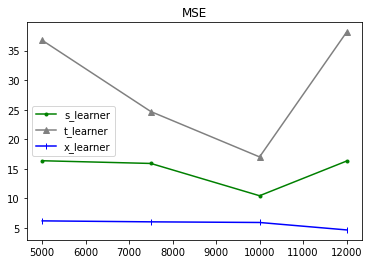

In [ ]:
fig1 = plt.gcf()
plt.plot(dataframe['sample_size'], dataframe['s_mse_eml_bart'], "green", label="s_learner", marker='.')
plt.plot(dataframe['sample_size'] ,dataframe['t_mse_eml_bart'], "grey",  label="t_learner", marker='^')
plt.plot(dataframe['sample_size'], dataframe['x_mse_eml_bart'], "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("MSE")
plt.show()
fig1.savefig("MSE_BART_SI1.png")

## SI-2: Complicated CATE Function

In [ ]:
cate_sl_list = []
cate_xl_list = []
cate_tl_list = []
T_te_list = []
X_te_list = []
S_te_list = []
# create ground truth
sigma_fixed = simulate_correlation_matrix(20, 0)
simulation_2_test = simulation(dim=20, size=500, e_x=0.5, sigma=sigma_fixed)
b1 = np.random.uniform(low=1, high=30, size=(simulation_2_test.dim,))
b0 = np.random.uniform(low=1, high=30, size=(simulation_2_test.dim,))

mu_0 = np.matmul(simulation_2_test.X, b0)
mu_1 = np.matmul(simulation_2_test.X, b1)
simulation_2_test.add_treatment_effect(mu_0, mu_1)

sample_sizes = np.array([100_000, 120_000])

for sample_size in tqdm(sample_sizes):
    simulation_2 = simulation(dim=20, size=sample_size, e_x=0.5, sigma=sigma_fixed)
    # b1 = np.random.uniform(low=1, high=30, size=(simulation_2.dim,))
    # b0 = np.random.uniform(low=1, high=30, size=(simulation_2.dim,))

    mu_0 = np.matmul(simulation_2.X, b0)
    mu_1 = np.matmul(simulation_2.X, b1)

    simulation_2.add_treatment_effect(mu_0, mu_1)
    n=5_000
    # Instantiate T learner
    models = RandomForestRegressor()
    # models = 
    T_learner = TLearner(models=models)
    # Train T_learner
    T_learner.fit(X=simulation_2.X, T=simulation_2.treatment , Y=simulation_2.Y_obs)
    # Estimate treatment effects on test data
    T_te = T_learner.effect(simulation_2_test.X)
    T_te_list.append(T_te)

    # # Instantiate S learner
    overall_model = RandomForestRegressor()
    S_learner = SLearner(overall_model=overall_model)
    # Train S_learner
    S_learner.fit(X=simulation_2.X, T=simulation_2.treatment , Y=simulation_2.Y_obs)
    # Estimate treatment effects on test data
    S_te = S_learner.effect(simulation_2_test.X)
    S_te_list.append(S_te)

    # # Instantiate X learner
    models = RandomForestRegressor()
    propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                      min_samples_leaf=int(n/100))
    X_learner = XLearner(models=models, propensity_model=propensity_model)
    # Train X_learner
    X_learner.fit(Y=simulation_2.Y_obs, T=simulation_2.treatment, X=simulation_2.X)
    # Estimate treatment effects on test data
    X_te = X_learner.effect(simulation_2_test.X)
    X_te_list.append(X_te)

    s_mse_eml_rf = [np.mean((est - simulation_2_test.ground_truth)**2) for est in S_te_list]
    x_mse_eml_rf = [np.mean((est - simulation_2_test.ground_truth)**2) for est in X_te_list]
    t_mse_eml_rf = [np.mean((est - simulation_2_test.ground_truth)**2) for est in T_te_list]
    
    results_mse_bart = pd.DataFrame(data={"s_mse_eml_rf":s_mse_eml_rf, 
                                 "t_mse_eml_rf":t_mse_eml_rf, 
                                 "x_mse_eml_rf": x_mse_eml_rf})
    
    results_mse_bart.to_csv(f"SL2_results_mse_rf_max_{sample_size}_ROUND_4.csv")

covariance is not positive-semidefinite.
100%|██████████| 8/8 [51:49<00:00, 388.63s/it]


In [ ]:
sl2_rf_mse = pd.read_csv('SL2_results_mse_rf_max_120000_ROUND_4.csv')
sl2_rf_mse['sample_size'] = sample_sizes

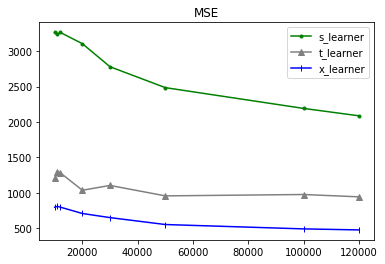

In [ ]:
fig1 = plt.gcf()
plt.plot(sl2_rf_mse['sample_size'], sl2_rf_mse['s_mse_eml_rf'], "green", label="s_learner", marker='.')
plt.plot(sl2_rf_mse['sample_size'] ,sl2_rf_mse['t_mse_eml_rf'], "grey",  label="t_learner", marker='^')
plt.plot(sl2_rf_mse['sample_size'], sl2_rf_mse['x_mse_eml_rf'], "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("MSE")
plt.show()
# fig1.savefig("SI2_RF_MSE.png")

In [ ]:
cate_sl_list = []
cate_xl_list = []
cate_tl_list = []
T_te_list = []
X_te_list = []
S_te_list = []
# create ground truth
sigma_fixed = simulate_correlation_matrix(20, 0)
simulation_2_test = simulation(dim=20, size=500, e_x=0.5, sigma=sigma_fixed)
b1 = np.random.uniform(low=1, high=30, size=(simulation_2_test.dim,))
b0 = np.random.uniform(low=1, high=30, size=(simulation_2_test.dim,))

mu_0 = np.matmul(simulation_2_test.X, b0)
mu_1 = np.matmul(simulation_2_test.X, b1)
simulation_2_test.add_treatment_effect(mu_0, mu_1)

# sample_sizes = np.array([7000, 8000, 8500])
sample_sizes = np.array([10_000, 12_000])
for sample_size in tqdm(sample_sizes):
    simulation_2 = simulation(dim=20, size=sample_size, e_x=0.5, sigma=sigma_fixed)
    # b1 = np.random.uniform(low=1, high=30, size=(simulation_2.dim,))
    # b0 = np.random.uniform(low=1, high=30, size=(simulation_2.dim,))

    mu_0 = np.matmul(simulation_2.X, b0)
    mu_1 = np.matmul(simulation_2.X, b1)

    simulation_2.add_treatment_effect(mu_0, mu_1)
    n=5_000
    # Instantiate T learner
    models = BART()
    # models = 
    T_learner = TLearner(models=models)
    # Train T_learner
    T_learner.fit(X=simulation_2.X, T=simulation_2.treatment , Y=simulation_2.Y_obs)
    # Estimate treatment effects on test data
    T_te = T_learner.effect(simulation_2_test.X)
    T_te_list.append(T_te)

    # # Instantiate S learner
    overall_model = BART()
    S_learner = SLearner(overall_model=overall_model)
    # Train S_learner
    S_learner.fit(X=simulation_2.X, T=simulation_2.treatment , Y=simulation_2.Y_obs)
    # Estimate treatment effects on test data
    S_te = S_learner.effect(simulation_2_test.X)
    S_te_list.append(S_te)

    # # Instantiate X learner
    models = BART()
    propensity_model = RandomForestClassifier(n_estimators=100, max_depth=6, 
                                                      min_samples_leaf=int(n/100))
    X_learner = XLearner(models=models, propensity_model=propensity_model)
    # Train X_learner
    X_learner.fit(Y=simulation_2.Y_obs, T=simulation_2.treatment, X=simulation_2.X)
    # Estimate treatment effects on test data
    X_te = X_learner.effect(simulation_2_test.X)
    X_te_list.append(X_te)

    s_mse_eml_bart = [np.mean((est - simulation_2_test.ground_truth)**2) for est in S_te_list]
    x_mse_eml_bart = [np.mean((est - simulation_2_test.ground_truth)**2) for est in X_te_list]
    t_mse_eml_bart = [np.mean((est - simulation_2_test.ground_truth)**2) for est in T_te_list]
    
    results_mse_bart = pd.DataFrame(data={"s_mse_eml_bart":s_mse_eml_bart, 
                                 "t_mse_eml_bart":t_mse_eml_bart, 
                                 "x_mse_eml_bart": x_mse_eml_bart})
    
    results_mse_bart.to_csv(f"SL2_results_mse_bart_max_{sample_size}_ROUND_2.csv")

covariance is not positive-semidefinite.
100%|██████████| 2/2 [28:12<00:00, 846.28s/it]


In [ ]:
df_1 = pd.read_csv(f"SL2_results_mse_bart_max_{8500}_ROUND_1.csv")
df_2 = pd.read_csv(f"SL2_results_mse_bart_max_{sample_size}_ROUND_2.csv")

In [ ]:
df_1

,Unnamed: 0,Unnamed: 0.1,s_mse_eml_bart,t_mse_eml_bart,x_mse_eml_bart,sample_sizes
0,0,0,1335.866008,269.392548,111.204931,5000
1,1,1,1264.001663,326.016557,111.525455,6000
2,2,2,973.768364,275.346093,90.346029,7000
3,0,0,1056.171401,251.142522,115.194133,8000
4,1,1,1061.127130,189.551937,107.050766,8500


In [ ]:
df_2['sample_sizes'] = sample_sizes

In [ ]:
df_2 = df_2[['s_mse_eml_bart', 't_mse_eml_bart', 'x_mse_eml_bart', "sample_sizes"]]
df_1 = df_1[['s_mse_eml_bart', 't_mse_eml_bart', 'x_mse_eml_bart', "sample_sizes"]]
df_total = pd.concat([df_1, df_2])
df_total

,s_mse_eml_bart,t_mse_eml_bart,x_mse_eml_bart,sample_sizes
0,1335.866008,269.392548,111.204931,5000
1,1264.001663,326.016557,111.525455,6000
2,973.768364,275.346093,90.346029,7000
3,1056.171401,251.142522,115.194133,8000
4,1061.127130,189.551937,107.050766,8500
0,1612.804187,248.131221,120.484941,10000
1,1171.756162,217.899269,130.673601,12000


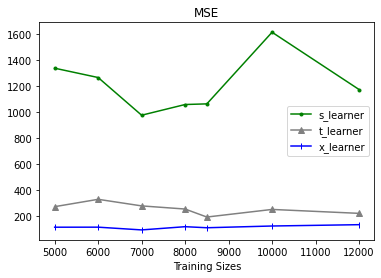

In [ ]:
fig1 = plt.gcf()
plt.plot(df_total['sample_sizes'], df_total['s_mse_eml_bart'], "green", label="s_learner", marker='.')
plt.plot(df_total['sample_sizes'] ,df_total['t_mse_eml_bart'], "grey",  label="t_learner", marker='^')
plt.plot(df_total['sample_sizes'], df_total['x_mse_eml_bart'], "blue",  label="x_learner", marker='|')
plt.legend()
plt.title("MSE")
plt.xlabel('Training Sizes')
plt.show()
fig1.savefig("SI2_BART_MSE.png")